<a href="https://colab.research.google.com/github/ProvenDruid/GANs/blob/main/gan_FMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import numpy as np
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import copy

import matplotlib.pyplot as plt
from IPython import display
from matplotlib_inline.backend_inline import set_matplotlib_formats

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# transformations
transform = T.Compose([ T.ToTensor(),
                        T.RandomHorizontalFlip(p=.5),
                        T.Normalize(.5,.5),
                       ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=True, transform=transform)

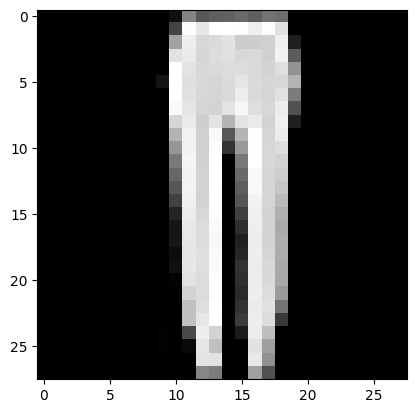

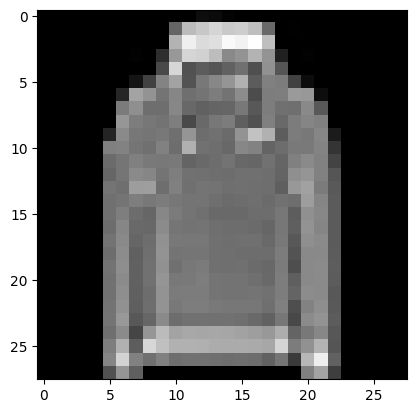

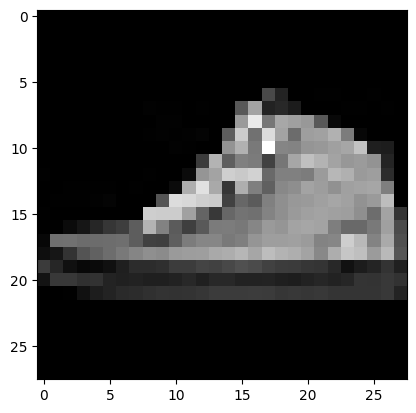

torch.Size([18000, 784])


In [ ]:
trousers=trainset.data[trainset.targets==1]
pullovers=trainset.data[trainset.targets==2]
sneakers=trainset.data[trainset.targets==7]
items = torch.cat((trousers, pullovers, sneakers), dim=0)
plt.imshow(items[5999], cmap="gray" )
plt.show()
plt.imshow(items[11999], cmap="gray" )
plt.show()
plt.imshow(items[17999], cmap="gray" )
plt.show()
items=items.reshape(18000,784).type(torch.float)
print(items.shape)
batchsize = 100

In [ ]:
#this net receives a vector of 728 pixels and then with a binary output decides if it's a real image or a fake image, it ends with a sigmoid because the loss function is BCELoss
class discriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()
                          #784
    self.fc1 = nn.Linear(28*28,256)
    self.fc2 = nn.Linear(256,256)
    self.out = nn.Linear(256,1)

  def forward(self,x):
    x = F.leaky_relu( self.fc1(x) )
    x = F.leaky_relu( self.fc2(x) )
    x = self.out(x)
    return torch.sigmoid( x )

dnet = discriminatorNet()
y = dnet(torch.randn(10,784))
y

tensor([[0.4969],
        [0.4899],
        [0.5127],
        [0.5284],
        [0.4834],
        [0.5155],
        [0.5307],
        [0.5060],
        [0.4817],
        [0.5150]], grad_fn=<SigmoidBackward0>)

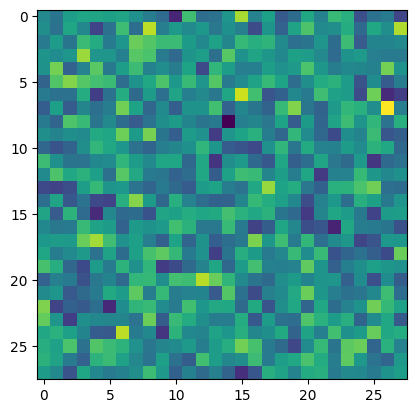

In [ ]:
#this net receives just noise but with each layer increases the size until the end where the output is 784, in this case representing the pixels for a 28x28 image
class generatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(64,256)
    self.fc2 = nn.Linear(256,256)
    self.out = nn.Linear(256,784)

  def forward(self,x):
    x = F.leaky_relu( self.fc1(x) )
    x = F.leaky_relu( self.fc2(x) )
    x = self.out(x)
    return torch.tanh( x )


gnet = generatorNet()
y = gnet(torch.randn(10,64))
plt.imshow(y[9,:].detach().squeeze().view(28,28));

In [ ]:
#the 2 nets are created, the loss function is defined and the optimizers are also defined
# loss function (same for both phases of training)
lossfun = nn.BCELoss()

# create instances of the models
dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

# optimizers (same algo but different variables b/c different parameters)
d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0003)
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0003)

In [ ]:
# this cell takes ~3 mins with 50k epochs
num_epochs = 150000

losses  = np.zeros((num_epochs,2))
disDecs = np.zeros((num_epochs,2)) # disDecs = discriminator decisions

for epochi in range(num_epochs):

  # create minibatches of REAL and FAKE images
  randidx     = torch.randint(items.shape[0],(batchsize,))
  real_images = items[randidx,:].to(device)
  fake_images = gnet( torch.randn(batchsize,64).to(device) ) # output of generator


  # labels used for real and fake images
  real_labels = torch.ones(batchsize,1).to(device)
  fake_labels = torch.zeros(batchsize,1).to(device)



  ### ---------------- Train the discriminator ---------------- ###

  # forward pass and loss for REAL pictures
  pred_real   = dnet(real_images)              # REAL images into discriminator
  d_loss_real = lossfun(pred_real,real_labels) # all labels are 1

  # forward pass and loss for FAKE pictures
  pred_fake   = dnet(fake_images)              # FAKE images into discriminator
  d_loss_fake = lossfun(pred_fake,fake_labels) # all labels are 0

  # collect loss (using combined losses)
  d_loss = d_loss_real + d_loss_fake
  losses[epochi,0]  = d_loss.item()
  disDecs[epochi,0] = torch.mean((pred_real>.5).float()).detach()

  # backprop
  d_optimizer.zero_grad()
  d_loss.backward()
  d_optimizer.step()




  ### ---------------- Train the generator ---------------- ###

  # create fake images and compute loss
  fake_images = gnet( torch.randn(batchsize,64).to(device) )
  pred_fake   = dnet(fake_images)

  # compute and collect loss and accuracy
  g_loss = lossfun(pred_fake,real_labels)
  losses[epochi,1]  = g_loss.item()
  disDecs[epochi,1] = torch.mean((pred_fake>.5).float()).detach()

  # backprop
  g_optimizer.zero_grad()
  g_loss.backward()
  g_optimizer.step()


  # print out a status message
  if (epochi+1)%500==0:
    msg = f'Finished epoch {epochi+1}/{num_epochs}'
    sys.stdout.write('\r' + msg)

Finished epoch 56000/150000

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([4000,5000])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(disDecs)
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

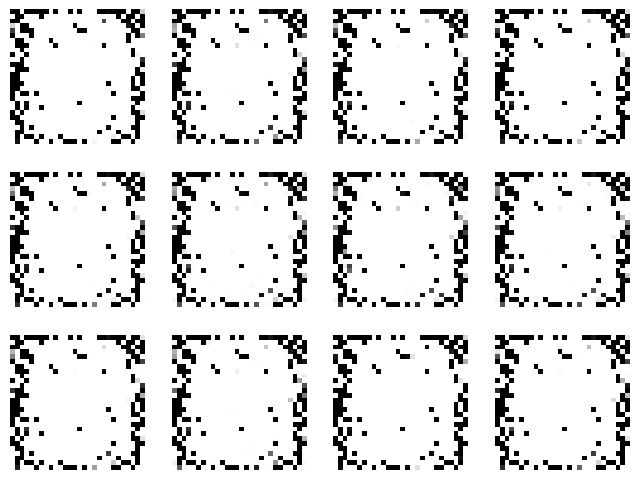

In [ ]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet(torch.randn(12,64).to(device)).cpu()

# and visualize...
fig,axs = plt.subplots(3,4,figsize=(8,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,:,].detach().view(28,28),cmap='gray')
  ax.axis('off')

plt.show()

In [ ]:
# transformations
transform = T.Compose([ T.ToTensor(),
                        T.Normalize(.5,.5),
                       ])

# import the data and simultaneously apply the transform
dataset = torchvision.datasets.FashionMNIST(root='./data', download=True, transform=transform)

In [ ]:
# list the categories
print(dataset.classes)

# pick three categories (leave one line uncommented)
# classes2keep = [ 'Trouser','Sneaker','Pullover' ]
classes2keep = [ 'Trouser','Sneaker', 'Sandal'  ]



# find the corresponding data indices
images2use = torch.Tensor()
for i in range(len(classes2keep)):
  classidx = dataset.classes.index(classes2keep[i])
  images2use = torch.cat( (images2use,torch.where(dataset.targets==classidx)[0]), 0).type(torch.long)
  print(f'Added class {classes2keep[i]} (index {classidx})')

# now select just those images

# transform to dataloaders
batchsize   = 100
sampler     = torch.utils.data.sampler.SubsetRandomSampler(images2use)
data_loader = DataLoader(dataset,sampler=sampler,batch_size=batchsize,drop_last=True)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Added class Trouser (index 1)
Added class Sneaker (index 7)
Added class Sandal (index 5)


In [ ]:
X.shape
X = X.view(batchsize,-1)
X.shape

torch.Size([100, 784])

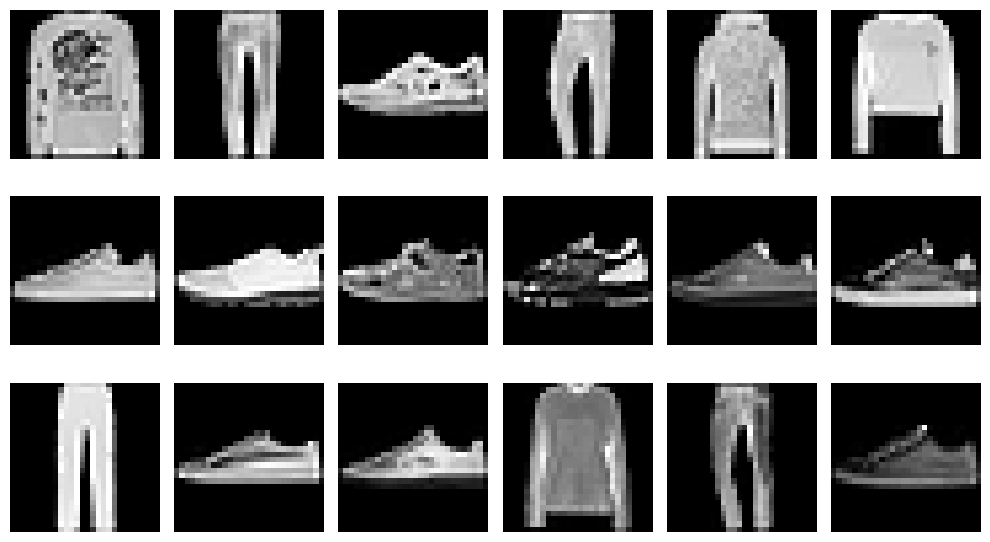

In [ ]:
# view some images
# inspect a few random images

randidx     = torch.randint(items.shape[0],(batchsize,))
real_images = items[randidx,:]

fig,axs = plt.subplots(3,6,figsize=(10,6))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image
  pic = real_images[i].reshape(28,28)
  pic = pic/2 + .5 # undo normalization

  # and its label
  label = dataset.classes[y[i]]

  # and show!
  ax.imshow(pic,cmap='gray')
  #ax.text(14,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
X,y = next(iter(data_loader))
print(X.shape)
X = X.view(batchsize,-1)
print(X.shape)

torch.Size([100, 1, 28, 28])
torch.Size([100, 784])


In [ ]:
randidx     = torch.randint(items.shape[0],(batchsize,))
real_images = items[randidx,:]
real_images.shape

torch.Size([100, 784])